# Topic modeling on IQOS reviews for DVOC ecosystem

Overview: 
Proof of concept of a topic modeling applied on the IQOS reviews coming from multiple web platform, the goal is to show a realization of a topic modelling using different techniques and applying innovations such as auto naming of the topics, automatic topic number selector

2022 Capgemini - DVOC Offer

## Python libraries importation 

The anaconda environment DVOC_topic_modeling_nb already has these libraries installed in it

In [1]:
# This gensim version has to be maintained for pretrained models for NETL algorithm 
# !pip install gensim==3.6.0 --user
import gensim
gensim.__version__

C:\Users\tankiset\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


'3.6.0'

In [2]:
import pandas as pd
import os
import numpy as np
import re, nltk
import spacy
import string
from collections import Counter
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from kneed import DataGenerator, KneeLocator


C:\Users\tankiset\Anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\tankiset\Anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Location of current working directory of a process

In [3]:
cwd = os.getcwd()
cwd

'C:\\Users\\tankiset\\Documents\\Internal Projects\\DVOC'

## Data Loading

Visualisation of the dataframe loaded 

In [4]:
# df = pd.read_csv('data/iqos_reviews_2021.csv',encoding="utf8")

df = pd.read_excel(pd.ExcelFile('data/iqos_reviews_2021.xlsx',engine="openpyxl"))

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.tail(2)

,business,website,location,date,stars,title,review
8614,NaN,NaN,NaN,NaT,NaN,NaN,...rigorous regulatory requirements. PMI’s smo...
8615,NaN,NaN,NaN,NaT,NaN,NaN,"Friday, December 11, 2020 Philip Morris Intern..."


## Missing values analysis

In [5]:
#Only check those columns where there are missing values as we have got a lot of columns
new_df = (df.isna()
            .sum()
            .to_frame('missing_count')
            .assign(missing_ratio = lambda x: x['missing_count']/len(df)*100)
            .loc[df.isna().any()] )
print(new_df)

          missing_count  missing_ratio
business           6056      70.287837
website            6056      70.287837
location           6056      70.287837
date               6030      69.986072
stars              6056      70.287837
title              6056      70.287837


## Word frequency analysis

In [6]:
df.dropna(subset=['review'], inplace=True)
df.reset_index(inplace = True)

from collections import Counter
results = Counter()
df['review'].str.lower().str.split().apply(results.update)
print(results)

Counter({'the': 22559, 'and': 19834, 'to': 11671, 'of': 9957, 'in': 9745, 'a': 8625, 'iqos': 6181, 'is': 5283, 'tobacco': 5248, 'as': 5057, 'for': 4963, 'i': 4597, 'that': 3980, 'products': 3161, 'with': 3109, 'it': 3107, 'on': 2799, 'smoke-free': 2785, 'products,': 2749, 'have': 2656, 'from': 2586, 'its': 2419, 'heets': 2348, 'nicotine-containing': 2343, 'are': 2163, 'you': 2067, 'philip': 2018, 'international': 2006, 'by': 1993, 'company': 1989, 'other': 1966, 'was': 1946, 'this': 1941, 'heated': 1932, 'my': 1886, 'not': 1816, 'morris': 1811, 'device': 1782, 'u.s.': 1767, 'has': 1754, 'they': 1659, 'or': 1624, 'be': 1598, 'under': 1597, 'product': 1576, 'devices': 1557, 'electronic': 1515, 'but': 1487, 'pmi': 1462, 'well': 1382, 'an': 1366, 'marlboro': 1346, 'markets': 1240, 'sale': 1237, 'vapor': 1198, 'will': 1180, '-': 1150, 'at': 1149, 'their': 1133, 'very': 1131, 'cigarettes,': 1103, 'more': 1099, 'including': 1085, 'so': 1077, 'which': 1050, 'smoking': 1046, 'like': 1041, 'new'

In [7]:
# Unique words in corpus
len(Counter(" ".join(df['review'].str.lower().values.tolist()).split(" ")).items())

34664

In [8]:
#Removing stop words and cleaning all the columns
def get_stop_words(stop_file_path):
    """load stop words """
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.lower().strip() for m in stopwords)
        return (stop_set)
    
#load a set of stop words
interm = get_stop_words("data/stop_words.txt")
interm = interm | {"a"} | {"the"}
stopwords=frozenset(interm)
print(stopwords)

frozenset({'has', 'those', 'were', 'through', 'will', 'now', 'hasn', "wouldn't", 'for', 'co', 'myself', "isn't", 'many', 'against', 'under', 'any', 'him', "needn't", 'com', 'why', 'most', 'she', "mustn't", 'themselves', 'ain', 'so', 'nor', 'is', 'isn', 'wouldn', 'this', 'own', "that'll", 'whom', "you've", 'did', 'it', 'down', 've', 'didn', 'ourselves', 'an', 'yourself', 'up', 'there', 'all', 'by', 'be', 'from', 'can', 'mustn', 'who', 'xx', 'yours', 'same', "didn't", 'once', 'these', 'its', 'to', 'not', 'in', 'about', 'while', 'his', 'each', 'with', 'or', "hadn't", 'itself', 'only', 'hers', 'off', 'yes', "don't", 'i', 'no', "won't", 'my', "it's", "shan't", 're', "she's", 'over', 'of', "you're", 'where', '\\\\', 'on', 'further', 'here', "hasn't", 'because', "shouldn't", 'until', 'below', 'how', 'https', 'aren', 'her', 'after', 'at', "you'd", 'what', 'doing', 'theirs', '...', 'into', 'when', 'you', 'between', "couldn't", 'should', 'and', 'won', 'does', 'shan', 'having', 'weren', 'have', '

In [9]:
def converter(x):
    try:
        return ' '.join([x.lower() for x in str(x).lower().split(' ') if x not in stopwords])
    except AttributeError:
        return None 
    
# applying fucntion to each comment question
df['review'] = df['review'].apply(converter)

In [10]:
# Unique words after removing stop words
print(len(Counter(" ".join(df['review'].str.lower().values.tolist()).split(" ")).items()))
Counter(" ".join(df['review'].str.lower().values.tolist()).split(" ")).most_common()[:15]

34508


[('iqos', 6157),
 ('tobacco', 5238),
 ('products', 3160),
 ('smoke-free', 2785),
 ('products,', 2749),
 ('heets', 2347),
 ('nicotine-containing', 2343),
 ('philip', 2014),
 ('international', 2006),
 ('company', 1989),
 ('heated', 1932),
 ('morris', 1811),
 ('device', 1781),
 ('u.s.', 1751),
 ('product', 1575)]

## Text cleaning

In [11]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'[#@{}ù➢*¬†Ä¢¬∑❑>Äôä]',' ', text) #removing special chars
    text = re.sub(r'[^\w\s]+', ' ',text) #removing punc
    text = re.sub('  ', ' ',text)#removing numbers
    text = re.sub("[\(\[].*?[\)\]-]", " ", text) #removing text withing brackets
    text = text.encode('ascii', 'ignore').decode() #keeps only ascii characters
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r'', text) # no emoji
    text = re.sub(r"[...]", "", text) # remove 3 dots
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) # remove twitter mentions and weblinks in text

    return text

df['review'] = df['review'].apply(lambda x: clean_text(x))

In [12]:
# Unique words after basic cleaning
print(len(Counter(" ".join(df['review'].str.lower().values.tolist()).split(" ")).items()))
Counter(" ".join(df['review'].str.lower().values.tolist()).split(" ")).most_common()[:15]

18989


[('', 18251),
 ('iqos', 7701),
 ('products', 6733),
 ('tobacco', 6104),
 ('s', 5547),
 ('smoke', 3961),
 ('heets', 3534),
 ('free', 3369),
 ('nicotine', 3309),
 ('pmi', 3061),
 ('cigarettes', 2550),
 ('company', 2521),
 ('containing', 2500),
 ('marlboro', 2357),
 ('device', 2341)]

In [13]:
df.head()

,index,business,website,location,date,stars,title,review
0,0,IQOS UK,uk.iqos.com,GBR,2021-02-10,5.0,Best employee Serena,hi problem device employee serena helpful well...
1,1,IQOS UK,uk.iqos.com,GBR,2021-02-10,5.0,Thamk you for your help,thamk help customer service serena kind helpf...
2,2,IQOS UK,uk.iqos.com,GBR,2021-02-10,5.0,Very fast customer service response,fast customer service response really impressed
3,3,IQOS UK,uk.iqos.com,GBR,2021-02-10,5.0,Nice and easy,nice easy helpful
4,4,IQOS UK,uk.iqos.com,GBR,2021-02-10,5.0,Iqos help team are fantastic and veryâ€¦,iqos help team fantastic helpful problem reso...


## Preprocessing of the text 

### Tokenization
Way of separating a piece of text into smaller units called tokens. Here the tokens are words. 

In [14]:
#Tokenise
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df.review))

print(data_words[:10])

[['hi', 'problem', 'device', 'employee', 'serena', 'helpful', 'well', 'mannered', 'cheers', 'her'], ['thamk', 'help', 'customer', 'service', 'serena', 'kind', 'helpfull', 'happy'], ['fast', 'customer', 'service', 'response', 'really', 'impressed'], ['nice', 'easy', 'helpful'], ['iqos', 'help', 'team', 'fantastic', 'helpful', 'problem', 'resolved', 'quickly', 'jamie'], [], [], ['helpful', 'got', 'information', 'need'], ['chris', 'kind', 'quickly', 'nice'], ['customer', 'service', 'brilliant', 'always']]


In [15]:
# Unique words after removing punctuation and gensim cleaning
print(len(Counter([item for sublist in data_words for item in sublist]).most_common()))
Counter([item for sublist in data_words for item in sublist]).most_common()[:15]

17876


[('iqos', 7708),
 ('products', 6733),
 ('tobacco', 6104),
 ('smoke', 3961),
 ('heets', 3536),
 ('free', 3369),
 ('nicotine', 3309),
 ('pmi', 3062),
 ('cigarettes', 2550),
 ('company', 2521),
 ('containing', 2500),
 ('marlboro', 2357),
 ('device', 2341),
 ('morris', 2319),
 ('international', 2317)]

### Lemmatization

Process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.
We define two different form of output from the lemmatization below:
- __lemmatization__: Input format adapted for the sklearn lda implementation
- __lemmatiization_gensim__: Input format adapted for the gensim lda implementation

In [16]:
import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')

lemma = nltk.wordnet.WordNetLemmatizer()
lemma.lemmatize('leaves')

'leaf'

In [17]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

def lemmatization_gensim(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags])
    return texts_out


__lemmatization__  

In [18]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB'])

print(data_lemmatized[:2])

['problem device employee serena cheer', 'customer service serena helpfull']


In [19]:
# Distinct words in the corpus
print(len(Counter(" ".join(data_lemmatized).split(" ")).most_common()))
Counter(" ".join(data_lemmatized).split(" ")).most_common()

8508


[('product', 8703),
 ('tobacco', 5966),
 ('smoke', 4951),
 ('iqos', 4157),
 ('device', 4063),
 ('cigarette', 3763),
 ('heet', 3550),
 ('nicotine', 3298),
 ('company', 2979),
 ('contain', 2616),
 ('heat', 2271),
 ('market', 2073),
 ('sale', 1981),
 ('include', 1763),
 ('marlboro', 1728),
 ('burn', 1651),
 ('accessory', 1463),
 ('brand', 1342),
 ('use', 1305),
 ('vapor', 1245),
 ('service', 1243),
 ('get', 1127),
 ('offer', 1048),
 ('customer', 1003),
 ('year', 957),
 ('manufacture', 941),
 ('sell', 917),
 ('patent', 910),
 ('pmi', 890),
 ('say', 876),
 ('receive', 833),
 ('com', 826),
 ('make', 806),
 ('marketing', 800),
 ('relate', 789),
 ('vape', 786),
 ('addition', 771),
 ('time', 762),
 ('platform', 728),
 ('smoking', 712),
 ('adult', 712),
 ('consumable', 694),
 ('stop', 674),
 ('day', 672),
 ('go', 659),
 ('system', 655),
 ('associate', 633),
 ('help', 632),
 ('https', 631),
 ('lead', 626),
 ('issue', 618),
 ('heatsticks', 616),
 ('risk', 591),
 ('version', 583),
 ('switch', 582),

__lemmatization_gensim__  

In [20]:
data_lemmatized_gensim = lemmatization_gensim(data_words, allowed_postags=['NOUN', 'VERB'])
print(data_lemmatized_gensim[:2])

[['problem', 'device', 'employee', 'serena', 'cheer'], ['customer', 'service', 'serena', 'helpfull']]


In [21]:
# Distinct words in the corpus

print(len(Counter([item for sublist in data_lemmatized_gensim for item in sublist ]).most_common()))
Counter([item for sublist in data_lemmatized_gensim for item in sublist ]).most_common()

8507


[('product', 8703),
 ('tobacco', 5966),
 ('smoke', 4951),
 ('iqos', 4157),
 ('device', 4063),
 ('cigarette', 3763),
 ('heet', 3550),
 ('nicotine', 3298),
 ('company', 2979),
 ('contain', 2616),
 ('heat', 2271),
 ('market', 2073),
 ('sale', 1981),
 ('include', 1763),
 ('marlboro', 1728),
 ('burn', 1651),
 ('accessory', 1463),
 ('brand', 1342),
 ('use', 1305),
 ('vapor', 1245),
 ('service', 1243),
 ('get', 1127),
 ('offer', 1048),
 ('customer', 1003),
 ('year', 957),
 ('manufacture', 941),
 ('sell', 917),
 ('patent', 910),
 ('pmi', 890),
 ('say', 876),
 ('receive', 833),
 ('com', 826),
 ('make', 806),
 ('marketing', 800),
 ('relate', 789),
 ('vape', 786),
 ('addition', 771),
 ('time', 762),
 ('platform', 728),
 ('smoking', 712),
 ('adult', 712),
 ('consumable', 694),
 ('stop', 674),
 ('day', 672),
 ('go', 659),
 ('system', 655),
 ('associate', 633),
 ('help', 632),
 ('https', 631),
 ('lead', 626),
 ('issue', 618),
 ('heatsticks', 616),
 ('risk', 591),
 ('version', 583),
 ('switch', 582),

### Vector transformation

In [22]:
vectorizer = CountVectorizer(analyzer='word',       
#                            min_df=5,#min_df is used for removing terms that appear too infrequently 
                             max_df=0.16, #max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words".
                             ngram_range=(1,1),
                             token_pattern='[a-zA-Z0-9]{3,}', # a word can contain numbers and alphabets of at least length 3 in order to be qualified as a word
                             stop_words = stopwords,
                             lowercase=True,                # already converte to lower case
#                            max_features=1000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [23]:
word_list = vectorizer.get_feature_names()  
count_list = data_vectorized.toarray().sum(axis=0)

In [24]:
# Unique words in the corpus (added bigrams using CountVectorizer)

print(len(dict(zip(word_list,count_list)).items()))
dict(zip(word_list,count_list)).items()

8324


dict_items([('aaahhht', 1), ('aaaht', 6), ('aac', 1), ('aadhaar', 1), ('aaomlbsb', 1), ('aapl', 2), ('abaaaaaht', 5), ('abandon', 13), ('abbreviate', 1), ('abbreviation', 2), ('abbv', 1), ('abbvie', 2), ('abhor', 1), ('abide', 2), ('ability', 61), ('abillity', 1), ('abnormality', 1), ('abolish', 2), ('abortion', 3), ('abpv', 2), ('absence', 10), ('absolve', 4), ('absorb', 16), ('absorption', 2), ('abstain', 1), ('abstinence', 1), ('absurd', 1), ('abt', 1), ('abundance', 1), ('abuse', 4), ('academician', 1), ('accelerate', 56), ('acceleration', 3), ('accelerator', 4), ('accenture', 2), ('accept', 37), ('acceptance', 14), ('access', 73), ('accessibility', 1), ('accessorie', 3), ('accesswire', 2), ('accident', 11), ('acclaim', 6), ('accommodate', 5), ('accommodation', 4), ('accomodation', 1), ('accompany', 7), ('accomplish', 11), ('accomplishment', 1), ('accord', 107), ('accordance', 3), ('accost', 1), ('account', 75), ('accountability', 5), ('accounting', 5), ('accumulate', 3), ('accumul

## Topic modeling on SKlearn

LDA modeling 

In [25]:
# Build LDA Model
fixed_seed = 100
lda_model = LatentDirichletAllocation(n_components=4,               # Number of topics
                                      max_iter=20,                  # Max learning iterations
                                      learning_method='online',   
                                      random_state=np.random.RandomState(fixed_seed),          # Random state
                                      batch_size=200,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=200, learning_method='online', max_iter=20,
                          n_components=4, n_jobs=-1,
                          random_state=RandomState(MT19937) at 0x20571CFE140)


#### Evaluation of the topic model through calculation of metrics: 

__Perplexity__ captures how surprised a model is of new data it has not seen before.

__Log-Likelihood__ measuring how probable some new unseen data is given the model that was learned earlier.

In [26]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word) 
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1078987.76815117
Perplexity:  916.7890081505043
{'batch_size': 200,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 20,
 'mean_change_tol': 0.001,
 'n_components': 4,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': RandomState(MT19937) at 0x20571CFE140,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


#### Dominant topics analysis

Identification of dominant topic for each document through the probability of membership of the document to a topic.


In [27]:
# Create Document - Topic Matrix
# lda_output = best_lda_model.transform(data_vectorized)
# this code helps us to get the top categories of topics i.e. dominant topcis from our word vectors

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,dominant_topic
Doc0,0.050000,0.250000,0.650000,0.050000,2
Doc1,0.050000,0.050000,0.850000,0.050000,2
Doc2,0.050000,0.050000,0.850000,0.050000,2
Doc3,0.250000,0.250000,0.250000,0.250000,0
Doc4,0.050000,0.050000,0.850000,0.050000,2
Doc5,0.250000,0.250000,0.250000,0.250000,0
Doc6,0.250000,0.250000,0.250000,0.250000,0
Doc7,0.060000,0.230000,0.650000,0.060000,2
Doc8,0.250000,0.250000,0.250000,0.250000,0
Doc9,0.060000,0.060000,0.810000,0.060000,2


In [28]:
df_document_topic=df_document_topic.loc[:,['dominant_topic']]
df_document_topic1= df_document_topic.reset_index()
df_document_topic1.head()

,index,dominant_topic
0,Doc0,2
1,Doc1,2
2,Doc2,2
3,Doc3,0
4,Doc4,2


In [29]:
df_topic_distribution = df_document_topic1['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,3513
1,1,2145
2,0,1981
3,3,977


#### Topics top keywords 

In [30]:
def show_topics(vectorizer=vectorizer,lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,heet,marlboro,brand,offer,vapor,relate,sell,heatsticks,parliament,dimension,manufacture,heatstick,launch,creation,industry,burn,cannabis,heating,see,use
Topic 1,burn,pmi,adult,patent,world,stop,switch,estimate,portfolio,smoker,consumer,vapor,year,import,meet,requirement,city,rule,preference,business
Topic 2,service,get,use,customer,vape,smoking,time,day,say,help,people,stick,make,year,thank,try,issue,problem,buy,take
Topic 3,marketing,addition,platform,receive,consumable,associate,version,food,manufacture,engage,authorization,drug,lead,administration,ship,system,authorize,license,stakeholder,risk


In [31]:
df_topic_keywords.to_csv("topic_keywords.csv")

#### Topics visualisation through PyLDA Vis

In [32]:
# # visualise the topic models
# pyLDAvis.enable_notebook()
# panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
# panel

#### General dataframe definition with dominant topics

In [33]:
df_concat_cases = pd.concat([df,df_document_topic1,pd.DataFrame(data_lemmatized,columns=['data_lemmatized'])],axis=1)
df_concat_cases.head()

,index,business,website,location,date,stars,title,review,index,dominant_topic,data_lemmatized
0,0,IQOS UK,uk.iqos.com,GBR,2021-02-10,5.0,Best employee Serena,hi problem device employee serena helpful well...,Doc0,2,problem device employee serena cheer
1,1,IQOS UK,uk.iqos.com,GBR,2021-02-10,5.0,Thamk you for your help,thamk help customer service serena kind helpf...,Doc1,2,customer service serena helpfull
2,2,IQOS UK,uk.iqos.com,GBR,2021-02-10,5.0,Very fast customer service response,fast customer service response really impressed,Doc2,2,customer service response impress
3,3,IQOS UK,uk.iqos.com,GBR,2021-02-10,5.0,Nice and easy,nice easy helpful,Doc3,0,
4,4,IQOS UK,uk.iqos.com,GBR,2021-02-10,5.0,Iqos help team are fantastic and veryâ€¦,iqos help team fantastic helpful problem reso...,Doc4,2,iqos help team problem resolve


## Automatic Topic Naming

### Using n-grams and tfidf by topic - Unigram model

In [34]:
# Xaxis = words, Yaxis=No.of documents containing the word 

keys = set(" ".join(data_lemmatized).split(" "))-set([""])
keys
counts = []
for k in keys:
    each_count=0
    for each_doc in data_lemmatized:
        if k in each_doc.split(" "):
            each_count+=1
    counts.append(each_count/df_concat_cases.shape[0])

# Note - Here counts for token 'service' represent the no.of docs (converted to a percentage) that have this word.
# So if there is one doc with multiple instances, it will still be counted as 1 word

Counter(dict(zip(keys,counts))).most_common()[:15]

[('tobacco', 0.4411559888579387),
 ('product', 0.43071030640668523),
 ('iqos', 0.41991643454038996),
 ('device', 0.3464484679665738),
 ('smoke', 0.34018105849582175),
 ('cigarette', 0.295380687093779),
 ('nicotine', 0.2822655524605385),
 ('company', 0.24454503249767873),
 ('contain', 0.24187558031569173),
 ('sale', 0.19568245125348188),
 ('heat', 0.19220055710306408),
 ('market', 0.18848653667595172),
 ('include', 0.18279944289693592),
 ('accessory', 0.1671309192200557),
 ('heet', 0.1562209842154132)]

<AxesSubplot:>

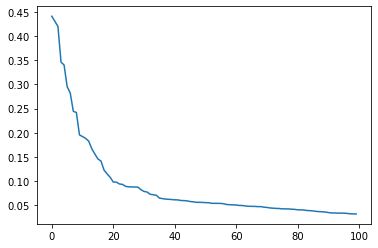

In [35]:
# x_range = int(df_concat_cases.shape[0])
x_range = 100

x=list(range(len(keys)))[:x_range]
y=sorted(counts,reverse=True)[:x_range]

sns.lineplot(x,y)

In [36]:
kneedle = KneeLocator(x, y, S=1, curve="convex", direction="decreasing")
print(kneedle.elbow)

b = Counter(dict(zip(keys,counts))).most_common()[kneedle.elbow]
print(b)

20
('customer', 0.09807335190343547)


In [37]:
# Rounding the threshold
 
max_df_threshold = b[1]-0.001
max_df_threshold

0.09707335190343547

In [38]:
# Build TfIdf vectorizer to find the important words

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer=TfidfVectorizer(use_idf=True, 
                                 ngram_range=(1,1),
                                 max_df = max_df_threshold,
                                 min_df = 10
                                ) 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(data_lemmatized)

print(tfidf_vectorizer_vectors.shape)
print(tfidf_vectorizer.get_feature_names()[:20])

(8616, 1467)
['abandon', 'ability', 'absence', 'accelerate', 'accept', 'acceptance', 'access', 'accident', 'accomplish', 'accord', 'account', 'accuse', 'achieve', 'achievement', 'acknowledge', 'acquire', 'acquisition', 'act', 'action', 'activity']


In [39]:
# Have a look at the tfIdf values for all documnets in corpus

df_all = pd.DataFrame(tfidf_vectorizer_vectors.todense(), 
                  # index=["Doc"+str(i) for i in range(tfidf_vectorizer_vectors.shape[0])],
                  columns=tfidf_vectorizer.get_feature_names(), 
                 )

print(df_all.shape)
df_all.head()

(8616, 1467)


,abandon,ability,absence,accelerate,accept,acceptance,access,accident,accomplish,accord,...,world,worry,wrap,write,www,year,yesterday,yield,youth,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# Labels for each topic are found by finding the important words in all documents that fall under that topic

for i in range(df_concat_cases.dominant_topic.nunique()):
    
    indx_topic = df_concat_cases[df_concat_cases.dominant_topic==i].index
    topic_defin_words = list(df_all.loc[indx_topic].mean().sort_values(ascending=False).index)
    
    print(f"Topic {i} : ", " - ".join(topic_defin_words[:3]))
    

Topic 0 :  marlboro - relate - sell
Topic 1 :  adult - patent - import
Topic 2 :  thank - help - problem
Topic 3 :  addition - platform - consumable


### Using n-grams and tfidf by topic - Bigram model

In [41]:
def get_topic_names(data_lemmatized, df_concat_cases, chosen_ngram_range = (2,2)):
    
    # identify n-grams that are stopwords 
    tfidf_vectorizer=CountVectorizer(analyzer='word', 
                                     ngram_range=chosen_ngram_range,
                                     min_df = 5) 
    tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(data_lemmatized)
    df_all = pd.DataFrame(tfidf_vectorizer_vectors.todense(), columns=tfidf_vectorizer.get_feature_names(), )
    keys = df_all.sum().sort_values(ascending=False).index
    counts = df_all.sum().sort_values(ascending=False).values


    # Using kneedle to find the elbow
    x_range = 100
    x=list(range(len(keys)))[:x_range]
    y=counts[:x_range]
    kneedle = KneeLocator(x, y, S=1, curve="convex", direction="decreasing")


    # Use elbow to find the max_df threshold
    b = Counter(dict(zip(keys,counts))).most_common()[kneedle.elbow]
    max_df_threshold = b[1]-1


    # Final bigrams after removing the stopwords using the above threshold
    tfidf_vectorizer=TfidfVectorizer(use_idf=True, 
                                     ngram_range=chosen_ngram_range,
                                     max_df = max_df_threshold,
                                     min_df = 5) 
    tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(data_lemmatized)
    df_all = pd.DataFrame(tfidf_vectorizer_vectors.todense(), 
                      columns=tfidf_vectorizer.get_feature_names())


    # Print the final topic names
    topic_names_dict = {}
    for i in range(df_concat_cases.dominant_topic.nunique()):
        indx_topic = df_concat_cases[df_concat_cases.dominant_topic==i].index
        topic_defin_words = list(df_all.loc[indx_topic].mean().sort_values(ascending=False).index)
        topic_names_dict[f"Topic {i}"] = topic_defin_words[:1][0]
    return topic_names_dict

a = get_topic_names(data_lemmatized, df_concat_cases, chosen_ngram_range = (2,2))
print(a)

{'Topic 0': 'heet marlboro', 'Topic 1': 'tobacco device', 'Topic 2': 'customer service', 'Topic 3': 'product market'}


In [42]:
tfidf_vectorizer=CountVectorizer(analyzer='word', 
                                 ngram_range=(2,2),
#                                  max_df = max_df_threshold,
                                 min_df = 5
                                ) 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(data_lemmatized)

print(tfidf_vectorizer_vectors.shape)
print(tfidf_vectorizer.get_feature_names()[:20])

(8616, 4125)
['abandon cigarette', 'ability communicate', 'ability meet', 'ability repatriate', 'ability tobacco', 'absence adult', 'accelerate conversion', 'accelerate pmi', 'accelerate smoke', 'accept appointment', 'access information', 'accessory company', 'accessory nicotine', 'acclaim develop', 'accord letter', 'accord people', 'accord pmi', 'accuse vape', 'achieve climate', 'achieve pmi']


In [43]:
# Have a look at the tfIdf values for all documnets in corpus

df_all = pd.DataFrame(tfidf_vectorizer_vectors.todense(), 
                  # index=["Doc"+str(i) for i in range(tfidf_vectorizer_vectors.shape[0])],
                  columns=tfidf_vectorizer.get_feature_names(), 
                 )

print(df_all.shape)
df_all.head()

(8616, 4125)


,abandon cigarette,ability communicate,ability meet,ability repatriate,ability tobacco,absence adult,accelerate conversion,accelerate pmi,accelerate smoke,accept appointment,...,year start,year switch,year think,year time,year tobacco,year try,year use,year warranty,year year,yield curve
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
keys = df_all.sum().sort_values(ascending=False).index
counts = df_all.sum().sort_values(ascending=False).values
Counter(dict(zip(keys,counts))).most_common()[:15]

[('smoke product', 2701),
 ('nicotine contain', 2435),
 ('device accessory', 1363),
 ('heat burn', 1296),
 ('contain product', 1291),
 ('heet marlboro', 1214),
 ('contain vapor', 1164),
 ('vapor product', 1159),
 ('product include', 920),
 ('tobacco nicotine', 909),
 ('include tobacco', 882),
 ('tobacco product', 873),
 ('product market', 858),
 ('product heet', 820),
 ('iqos smoke', 812)]

<AxesSubplot:>

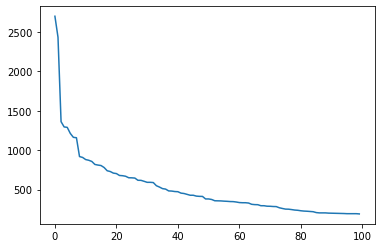

In [45]:
x_range = 100

x=list(range(len(keys)))[:x_range]
y=counts[:x_range]

sns.lineplot(x,y)

In [46]:
kneedle = KneeLocator(x, y, S=1, curve="convex", direction="decreasing")
print(kneedle.elbow)

b = Counter(dict(zip(keys,counts))).most_common()[kneedle.elbow]
print(b)

10
('include tobacco', 882)


In [47]:
# Rounding the threshold
 
max_df_threshold = b[1]-1
max_df_threshold

881

In [48]:
# Build TfIdf vectorizer to find the important words

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer=TfidfVectorizer(use_idf=True, 
                                 ngram_range=(2,2),
                                 max_df = max_df_threshold,
                                 min_df = 5
                                ) 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(data_lemmatized)

print(tfidf_vectorizer_vectors.shape)
print(tfidf_vectorizer.get_feature_names()[:20])

(8616, 4115)
['abandon cigarette', 'ability communicate', 'ability meet', 'ability repatriate', 'ability tobacco', 'absence adult', 'accelerate conversion', 'accelerate pmi', 'accelerate smoke', 'accept appointment', 'access information', 'accessory company', 'accessory nicotine', 'acclaim develop', 'accord letter', 'accord people', 'accord pmi', 'accuse vape', 'achieve climate', 'achieve pmi']


In [49]:
# Have a look at the tfIdf values for all documnets in corpus

df_all = pd.DataFrame(tfidf_vectorizer_vectors.todense(), 
                  # index=["Doc"+str(i) for i in range(tfidf_vectorizer_vectors.shape[0])],
                  columns=tfidf_vectorizer.get_feature_names(), 
                 )

print(df_all.shape)
df_all.head()

(8616, 4115)


,abandon cigarette,ability communicate,ability meet,ability repatriate,ability tobacco,absence adult,accelerate conversion,accelerate pmi,accelerate smoke,accept appointment,...,year start,year switch,year think,year time,year tobacco,year try,year use,year warranty,year year,yield curve
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# for i in ["accept",'customer service', 'customer support', 'service thank']:
#     if i in tfidf_vectorizer.get_feature_names():
#         print(i)

In [51]:
# Labels for each topic are found by finding the important words in all documents that fall under that topic

for i in range(df_concat_cases.dominant_topic.nunique()):
    
    indx_topic = df_concat_cases[df_concat_cases.dominant_topic==i].index
    topic_defin_words = list(df_all.loc[indx_topic].mean().sort_values(ascending=False).index)
    
    print(f"Topic {i} : ", " - ".join(topic_defin_words[:1]))
    

Topic 0 :  heet marlboro
Topic 1 :  tobacco device
Topic 2 :  customer service
Topic 3 :  product market


In [52]:
# main_list = tfidf_vectorizer.get_feature_names()
# sub_list = [u[0] for u in Counter(dict(zip(keys,counts))).most_common()[:kneedle.elbow]]
# for i in sub_list:
#     if i in main_list:
#         print(i)
        
# sub_list
# main_list

In [53]:
# Topic 0 :  product customer - service product - smoke cigarette
# Topic 1 :  solve problem - service thank - customer support
# Topic 2 :  service recommend - day delivery - buy heet
# Topic 3 :  flight option - flight hotel - change flight

### Pre-Trained models & Text Summarization

In [3]:
# Automatic labeeling of topics using neural embeddings using pretrained models on Wikipedia

# https://github.com/sb1992/NETL-Automatic-Topic-Labelling-/tree/4ed0f0853ee7bb162945c13f1d49230b04a3d5f7

In [4]:
initial_cwd = os.getcwd()
initial_cwd

'C:\\Users\\tankiset\\Documents\\Internal Projects\\DVOC'

In [5]:
os.chdir("C:\\Users\\tankiset\\Documents\\Internal Projects\\DVOC\\NETL-Automatic-Topic-Labelling--master\\model_run")

In [6]:
os.getcwd()

'C:\\Users\\tankiset\\Documents\\Internal Projects\\DVOC\\NETL-Automatic-Topic-Labelling--master\\model_run'

In [8]:
# %run get_labels -cg -us -s

In [9]:
from gensim.models import Doc2Vec

In [10]:
from numpy import exp, log, dot, zeros, outer, random, dtype, float32 as REAL,\
    double, uint32, seterr, array, uint8, vstack, fromstring, sqrt, newaxis,\
ndarray, empty, sum as np_sum, prod, ones, ascontiguousarray

In [11]:
import pickle
with open("support_files//doc2vec_indices",'rb') as m:   
    d_indices=pickle.load(m)
d_indices = list(set(d_indices))

In [12]:
model1 =Doc2Vec.load("pre_trained_models//doc2vec//docvecmodel.d2v")

In [13]:
model1.syn0norm = (model1.wv.syn0 / sqrt((model1.wv.syn0 ** 2).sum(-1))[..., newaxis]).astype(REAL)

# model1.docvecs.doctag_syn0norm =  (model1.docvecs.doctag_syn0 / sqrt((model1.docvecs.doctag_syn0 ** 2).sum(-1))[..., newaxis]).astype(REAL)[d_indices]
model1.docvecs.vectors_docs =  (model1.docvecs.doctag_syn0 / sqrt((model1.docvecs.doctag_syn0 ** 2).sum(-1))[..., newaxis]).astype(REAL)[d_indices]

print( "doc2vec normalized")

doc2vec normalized


In [15]:
model1.wv.vocab

{'': <gensim.models.deprecated.keyedvectors.Vocab at 0x12fda130370>,
 'tripolitan': <gensim.models.deprecated.keyedvectors.Vocab at 0x12fd90710d0>,
 'soestdijk': <gensim.models.deprecated.keyedvectors.Vocab at 0x12fd90d1e80>,
 'verplank': <gensim.models.deprecated.keyedvectors.Vocab at 0x12fd90d6160>,
 'luanco': <gensim.models.deprecated.keyedvectors.Vocab at 0x12fd90dc880>,
 'maderista': <gensim.models.deprecated.keyedvectors.Vocab at 0x12fd90e2640>,
 'biysk': <gensim.models.deprecated.keyedvectors.Vocab at 0x12fd90e2a90>,
 'spiders': <gensim.models.deprecated.keyedvectors.Vocab at 0x12fd90edb20>,
 'mdbs': <gensim.models.deprecated.keyedvectors.Vocab at 0x12fd90f2970>,
 'fabianism': <gensim.models.deprecated.keyedvectors.Vocab at 0x12fd90f9790>,
 'sperrylite': <gensim.models.deprecated.keyedvectors.Vocab at 0x12fd907d0d0>,
 'godaan': <gensim.models.deprecated.keyedvectors.Vocab at 0x12fd90b1b20>,
 'kalmar': <gensim.models.deprecated.keyedvectors.Vocab at 0x12fda12bc70>,
 'spidery': <g

In [16]:
a = {1:1, 2:2}

In [18]:
list(a)

[1, 2]

In [ ]:
# Text summarization

import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device('cpu')

# Just pass the top 100 reviews
text = ". ".join(df_concat_cases[df_concat_cases.dominant_topic==i].review[:100])


preprocess_text = text.strip().replace("\n","")
t5_prepared_Text = "summarize: "+preprocess_text

# Printing only the first 1000 characters of the original text
print ("original text preprocessed: \n", preprocess_text[:1000])

tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)

# summmarize 
summary_ids = model.generate(tokenized_text,
                                    num_beams=4,
                                    no_repeat_ngram_size=2,
                                    min_length=5,
                                    max_length=50,
                                    early_stopping=True)

output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print ("\n\nSummarized text: \n",output)

### Lingo algorithm (Java developed)

Carrot2 (Java) is an implementation of the Lingo algorithm allowing to cluster topics and find a name for each one,
using the API we connect our notebook to it to retrieve topic names. 

In [ ]:
import requests
import json
import os

In [ ]:
os.startfile("carrot2-4.4.2\dcs\dcs.cmd")

dict_df_topic0 = df_concat_cases.loc[df_concat_cases['dominant_topic'] == 0]["review"]
dict_df_topic1 = df_concat_cases.loc[df_concat_cases['dominant_topic'] == 1]["review"]
dict_df_topic2 = df_concat_cases.loc[df_concat_cases['dominant_topic'] == 2]["review"]
dict_df_topic3 = df_concat_cases.loc[df_concat_cases['dominant_topic'] == 3]["review"]
dict_df_topic4 = df_concat_cases.loc[df_concat_cases['dominant_topic'] == 4]["review"]
dict_df_topic5 = df_concat_cases.loc[df_concat_cases['dominant_topic'] == 5]["review"]
dict_df_topic6 = df_concat_cases.loc[df_concat_cases['dominant_topic'] == 6]["review"]
dict_df_topic7 = df_concat_cases.loc[df_concat_cases['dominant_topic'] == 7]["review"]
dict_df_topic8 = df_concat_cases.loc[df_concat_cases['dominant_topic'] == 8]["review"]

def topic_naming(dict_df_topic):

    json_dict_review =[]
    for index, value in dict_df_topic.items():
        json_dict_review.append({"review": value})

    body = {
      "language": "English",
      "algorithm": "Lingo",
      "parameters": {
        "clusterBuilder": {
        "clusterMergingThreshold": 0.9,
        "labelAssigner": {
            "@type": "SimpleLabelAssigner"
        }
        },
        "desiredClusterCount": 2,
        "preprocessing": {
          "phraseDfThreshold": 1,
          "wordDfThreshold": 1
        }
      },
      "documents": json_dict_review
    }
    
    

    url = "http://localhost:8080/service/cluster?indent"

    resp = requests.post(url, data = json.dumps(body))
    respText = json.loads(resp.text)
    #print(respText)
    output_list =[]
    for k,v in respText.items():
        for element in v:
            output_list.append(element['labels'][0])
    return output_list
            

In [ ]:
# Visualisation of the distribution of dominant topics with their automatic topic naming 

df_value_dominant = df_concat_cases['dominant_topic'].value_counts(ascending=True)
df_value_dominant.index = [topic_naming(dict_df_topic0)[0],
                           topic_naming(dict_df_topic1)[0],
                           topic_naming(dict_df_topic2)[0], 
                           topic_naming(dict_df_topic3)[0],    
#                            topic_naming(dict_df_topic4)[0],    
                          ]

df_value_dominant.plot.bar()

## Topic modeling on gensim 

Implementiation of the __Online Learning for LDA - Hoffman et al.__ 

Parameters: 
- Corpus: Stream of document vectors
- id2word: Mapping word IDs to words
- num_topics: Number of requested latent topics to be extracted from the training corpus
- random_state: RandomState object or a seed to generate one (Useful for reproducibility)
- update_every: Number of documents to be iterated through for each update : 0 for batch learning, 1 for online iterative learning
- chunksize: Number of documents to be used in each training chunk 
- passes: Number of passes through the corpus during training
- per_word_topics: If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word, along with their phi values multiplied by the feature length (i.e. word count)

__Example below__

In [ ]:
# To estimate total topics 
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_lemmatized_gensim)

# Create Corpus
texts = data_lemmatized_gensim

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
fixed_seed = 100
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=np.random.RandomState(fixed_seed),
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)

In [ ]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized_gensim, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
# vis

### Find the right number of topics on gensim 

Based on the coherence score metrics, we find the right value to identify the right number of topics for our topic model.
However we have to find a trade-off between the computation time and the number of lda models tested for each topic number. 

In [ ]:
def compute_coherence_score(topic_range=[2,30],corpus=corpus,id2word=id2word, update_every=1, chunksize=300, passes=10, per_word_topics=True):
    coherence_list = []
    nb_topics_list = [x for x in range(topic_range[0], topic_range[1])]
    for i in nb_topics_list:
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=np.random.RandomState(fixed_seed),
                                           update_every=1,
                                           chunksize=300,
                                           passes=10,
                                           per_word_topics=True)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized_gensim, dictionary=id2word, coherence='u_mass')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_list.append(coherence_lda)
        
    return nb_topics_list, coherence_list

In [ ]:
coherence_scores = compute_coherence_score()

In [ ]:
plt.plot(coherence_scores[0], coherence_scores[1])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Our goal is to find the elbow point based on the above graph analysis

### In construction: Automatic elbow point finder using kneed

We plan to use a polynomial regression to automate the search of the elbow point

In [ ]:
x = np.asarray(coherence_scores[0])
y = np.asarray(coherence_scores[1])
X = x[:,np.newaxis]
Y = y[:,np.newaxis]

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, Y)
y_predicted = poly_reg_model.predict(poly_features)

In [ ]:
y_predicted

In [ ]:
plt.scatter(coherence_scores[0], coherence_scores[1])
plt.plot(x, y_predicted, c="red")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
from kneed import DataGenerator, KneeLocator
kneedle = KneeLocator(x, y_predicted.flatten(), S=1.0, curve="concave", direction="decreasing")
print(kneedle.elbow)

In [ ]:
x

In [ ]:
y_predicted.flatten()

## Cleaning steps

In [ ]:
text = "...RT @phil_w888 @TC_BMJ @theodorecaputi You used the (intentionally misnamed) 'EVALI' fiasco to market a dishonest \
narrative that nicotine vapes had something to do with it. At least some people benefit from IQOS. Your product provides \
zero benefit and, unlike IQOS, has killed people. https://t.co/eRMSjJtNq9"

text = re.sub(r"[...]", "", text) # remove 3 dots
text = re.sub(r"(?:\@|https?\://)\S+", "", text) # remove twitter mentions and weblinks in text
text

In [ ]:
text = "RT @chaisalterego My whole office smokes these electric cigarettes called iqos and it smells like farts 😭😭😭"

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

text = emoji_pattern.sub(r'', text) # no emoji
text

In [ ]:
df = pd.read_excel(pd.ExcelFile('data/iqos_reviews_2021.xlsx',engine="openpyxl"))
df = df.iloc[:2565,:]

In [ ]:
df.Date = df.Date.dt.date

In [ ]:
df

In [ ]:
df = pd.read_excel(pd.ExcelFile('data/iqos_reviews_2021.xlsx',engine="openpyxl"))


In [ ]:
df.shape

In [ ]:
#Tokenise

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df.Review))

print(len(data_words))
print(data_words[:10])